<a href="https://colab.research.google.com/github/2haed/sber_test/blob/main/ready_project.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [2]:
!pip install catboost

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
     |████████████████████████████████| 76.6 MB 1.2 MB/s 


In [3]:
!git lfs clone 'https://github.com/2haed/sber_test' repo

          with new flags from 'git clone'

'git clone' has been updated in upstream Git to have comparable
speeds to 'git lfs clone'.
Cloning into 'repo'...
remote: Enumerating objects: 32, done.
remote: Counting objects: 100% (32/32), done.
remote: Compressing objects: 100% (28/28), done.
remote: Total 32 (delta 8), reused 20 (delta 4), pack-reused 0
Unpacking objects: 100% (32/32), done.
Git LFS: (3 of 3 files) 230.55 MB / 230.55 MB


In [4]:
import pandas as pd
import pickle
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from catboost import CatBoostClassifier
from sklearn.model_selection import GridSearchCV, train_test_split
from sklearn.preprocessing import StandardScaler
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import confusion_matrix, roc_curve
from sklearn.metrics import recall_score, precision_score

In [5]:
def get_data(filename) -> pd.DataFrame:
    with open(f'repo/data/{filename}.csv', 'r', encoding='utf-8') as file:
        data_frame = pd.read_csv(file, index_col=0, low_memory=False) * 1
        return data_frame

In [6]:
def normalize_person_data(df) -> pd.DataFrame:
    normal_data = df[['person_id']]
    to_normalize = df.drop(['date', 'person_id'], axis=1).apply(lambda x: pd.factorize(x)[0])
    to_normalize = (to_normalize - to_normalize.min()) / (to_normalize.max() - to_normalize.min())
    df = pd.concat([normal_data, to_normalize], axis=1)
    return df

In [7]:
def normalize_action_data(df) -> pd.DataFrame:
    normal_data = df[['person_id', 'action_type', 'action_id']]
    to_normalize = df.drop(['person_id', 'date', 'action_type', 'action_id'], axis=1).apply(
        lambda x: pd.factorize(x)[0])
    to_normalize = (to_normalize - to_normalize.min()) / (to_normalize.max() - to_normalize.min())
    df = pd.concat([normal_data, to_normalize], axis=1)
    df = pd.get_dummies(df, columns=["action_type"])
    return df

In [8]:
def get_redundant_pairs(df: pd.DataFrame) -> set:
    pairs_to_drop = set()
    cols = df.columns
    for i in range(0, df.shape[1]):
        for j in range(0, i + 1):
            pairs_to_drop.add((cols[i], cols[j]))
    return pairs_to_drop

In [9]:
def get_top_abs_correlations(df: pd.DataFrame, n: int = 5) -> pd.DataFrame:
    au_corr = df.corr().abs().unstack()
    labels_to_drop = get_redundant_pairs(df)
    au_corr = au_corr.drop(labels=labels_to_drop).sort_values(ascending=False)
    return au_corr[0:n]

In [10]:
def draw_importances(train_df: pd.DataFrame, rfc: RandomForestClassifier) -> None:
    feats = {}
    for feature, importance in zip(train_df.columns, rfc.feature_importances_):
        feats[feature] = importance
    importances = pd.DataFrame.from_dict(feats, orient='index').rename(columns={0: 'Gini-Importance'})
    importances = importances.sort_values(by='Gini-Importance', ascending=False)
    importances = importances.reset_index()
    importances = importances.rename(columns={'index': 'Features'})
    sns.set(font_scale=5)
    sns.set(style="whitegrid", color_codes=True, font_scale=1.7)
    fig, ax = plt.subplots()
    fig.set_size_inches(30, 15)
    sns.barplot(x=importances['Gini-Importance'], y=importances['Features'], data=importances, color='skyblue')
    plt.xlabel('Importance', fontsize=25, weight='bold')
    plt.ylabel('Features', fontsize=25, weight='bold')
    plt.title('Feature Importance', fontsize=25, weight='bold')
    plt.show()

In [11]:
test = normalize_action_data(get_data('action_test'))
train = normalize_action_data(get_data('action_train'))
person = normalize_person_data(get_data('person'))

In [12]:
train_df = pd.merge(train, person, on='person_id', suffixes=('_action', '_person')).set_index(
    ['action_id', 'person_id'])
test_df = pd.merge(test, person, on='person_id', suffixes=('_action', '_person')).set_index(
    ['action_id', 'person_id'])

Обучение модели на тестовом дата сете

In [13]:
X = train_df.drop(['result'], axis=1)
y = train_df.result
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.33, random_state = 42)

ss = StandardScaler()
X_train_scaled = ss.fit_transform(X_train)
X_test_scaled = ss.transform(X_test)
y_train = np.array(y_train)

Модель случайного леса до очистки данных для сравнения

Получение гиперпараметров с помощью RandomizedSearchCV для RandomForestClassifier (**Очень долгий процесс**, результат уже получен в pickle формате)


In [ ]:
clf = RandomForestClassifier()
n_estimators = [int(x) for x in np.linspace(start=500, stop=1000, num=100)]
max_features = ['log2', 'sqrt']
max_depth = [int(x) for x in np.linspace(start=2, stop=20, num=15)]
min_samples_split = [int(x) for x in np.linspace(start=2, stop=20, num=10)]
min_samples_leaf = [int(x) for x in np.linspace(start=2, stop=20, num=10)]
bootstrap = [True, False]
param_dist = {'n_estimators': n_estimators,
              'max_features': max_features,
              'max_depth': max_depth,
              'min_samples_split': min_samples_split,
              'min_samples_leaf': min_samples_leaf,
              'bootstrap': bootstrap}
random_search_clf = RandomizedSearchCV(clf,
                                       param_dist,
                                       cv=3,
                                       verbose=3,
                                       n_jobs=-1,
                                       random_state=0)
random_search_clf.fit(X_train_scaled, y_train)
best_clf = random_search_clf.best_estimator_
with open("repo/data/models/forest_randomized_search_cv_best_estimator.pkl", "wb") as pickle_file:
    pickle.dump(best_clf, pickle_file)

In [14]:
with open('repo/data/models/forest_randomized_search_cv_best_estimator.pkl', 'rb') as pickle_file:
    forest_clf = pickle.load(pickle_file)

y_prob_forest = forest_clf.predict_proba(X_test_scaled)[:, 1]
y_pred_forest = forest_clf.predict(X_test_scaled)

/usr/local/lib/python3.7/dist-packages/sklearn/base.py:338: UserWarning: Trying to unpickle estimator DecisionTreeClassifier from version 1.1.3 when using version 1.0.2. This might lead to breaking code or invalid results. Use at your own risk. For more info please refer to:
https://scikit-learn.org/stable/modules/model_persistence.html#security-maintainability-limitations
  UserWarning,
/usr/local/lib/python3.7/dist-packages/sklearn/base.py:338: UserWarning: Trying to unpickle estimator RandomForestClassifier from version 1.1.3 when using version 1.0.2. This might lead to breaking code or invalid results. Use at your own risk. For more info please refer to:
https://scikit-learn.org/stable/modules/model_persistence.html#security-maintainability-limitations
  UserWarning,


Модель Cat Boost после очистки

In [15]:
corr_matrix = X_train.corr().abs()
upper = corr_matrix.where(np.triu(np.ones(corr_matrix.shape), k=1).astype(np.bool))
to_drop = [column for column in upper.columns if any(upper[column] > 0.85)]
X_train.drop(to_drop, axis=1, inplace=True)
X_test.drop(to_drop, axis=1, inplace=True)

/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:2: DeprecationWarning: `np.bool` is a deprecated alias for the builtin `bool`. To silence this warning, use `bool` by itself. Doing this will not modify any behavior and is safe. If you specifically wanted the numpy scalar type, use `np.bool_` here.
Deprecated in NumPy 1.20; for more details and guidance: https://numpy.org/devdocs/release/1.20.0-notes.html#deprecations
  


In [16]:
ss = StandardScaler()
X_train_scaled = ss.fit_transform(X_train)
X_test_scaled = ss.transform(X_test)
y_train = np.array(y_train)

In [17]:
rfc = RandomForestClassifier()
rfc.fit(X_train_scaled, y_train)
rfc.score(X_train_scaled, y_train)

0.9847267732837743

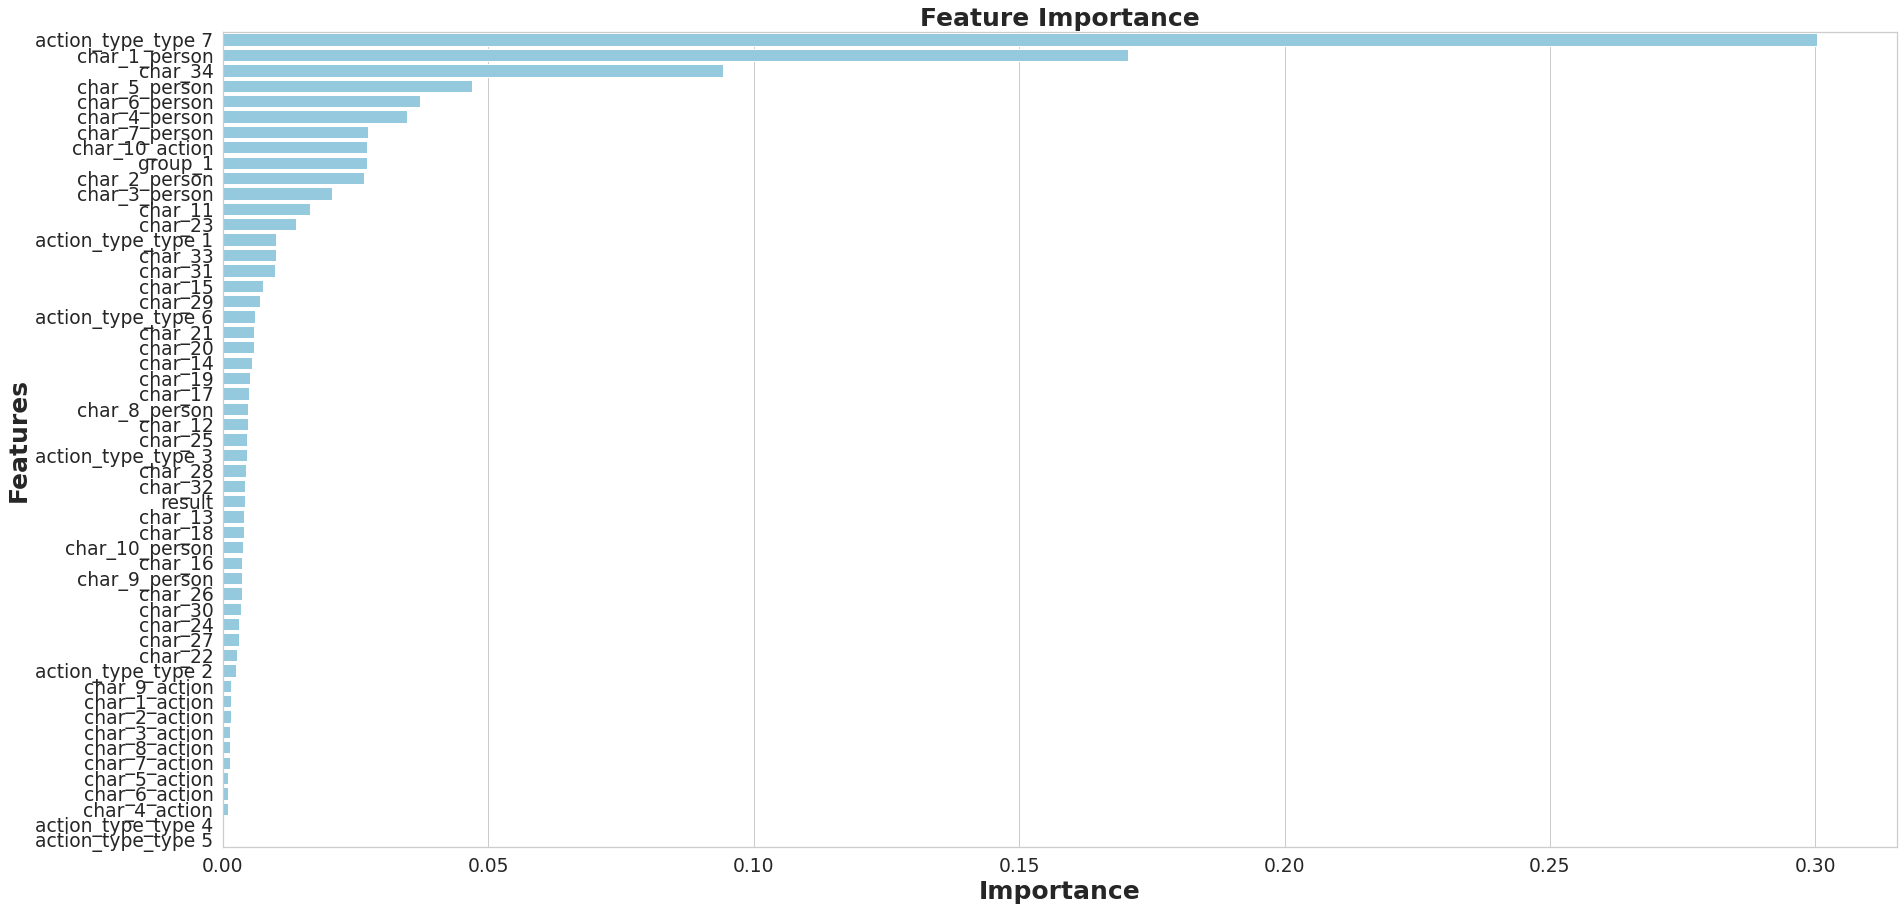

In [18]:
draw_importances(train_df, rfc)

Получение гиперпараметров с помощью GridSearchCV для CatBoostClassifier 
(**Очень долгий процесс**, результат уже получен в pickle формате)

In [ ]:
clf = CatBoostClassifier(early_stopping_rounds=200, task_type='GPU', loss_function='MultiClass')

params = {'depth': [4, 6, 10],
          'learning_rate': [0.05, 0.1, 0.15],
          'l2_leaf_reg': [1, 4, 9],
          'iterations': [10, 100, 300, 500, 1000],
          'early_stopping_rounds': [1000],
          'loss_function': ['MultiClass'],
          }
grid_search_cv_clf = GridSearchCV(clf, 
                                  param_grid=params, 
                                  scoring="accuracy", 
                                  cv=3, 
                                  verbose=3)
grid_search_cv_clf.fit(X_train_scaled, y_train)
best_clf = grid_search_cv_clf.best_estimator_
with open("repo/data/models/catboost_randomized_search_cv.pkl", "wb") as pickle_file:
    pickle.dump(best_clf, pickle_file)

In [19]:
with open('repo/data/models/catboost_randomized_search_cv.pkl', 'rb') as pickle_file:
    catboost_clf = pickle.load(pickle_file)
best_params = catboost_clf.get_params()
y_prob_catboost = catboost_clf.predict_proba(X_test_scaled)[:, 1]
y_pred_catboost = catboost_clf.predict(X_test_scaled)

In [20]:
conf_matrix_random_forest_best_clf = pd.DataFrame(confusion_matrix(y_test, y_pred_forest),
                                             index=['actual F', 'actual T'],
                                             columns=['predicted F', 'predicted T'])
print(conf_matrix_random_forest_best_clf)
print(f'Random Forest recall score Best classifier, {recall_score(y_test, y_pred_forest)},\nCat Boost precision score regular classifier {precision_score(y_test, y_pred_forest)}')

conf_matrix_cat_boost_best_clf = pd.DataFrame(confusion_matrix(y_test, y_pred_catboost),
                                                           index=['actual F', 'actual T'],
                                                           columns=['predicted F', 'predicted T'])
print(conf_matrix_cat_boost_best_clf)
print(f'Cat Boost recall score regular classifier, {recall_score(y_test, y_pred_catboost)},\nCat Boost precision score regular classifier {precision_score(y_test, y_pred_catboost)}')

          predicted F  predicted T
actual F       310020        93498
actual T         2374       319215
Random Forest recall score Best classifier, 0.992617906707008,
Cat Boost precision score regular classifier 0.7734551613348744
          predicted F  predicted T
actual F       388533        14985
actual T         6563       315026
Cat Boost recall score regular classifier, 0.9795919636554733,
Cat Boost precision score regular classifier 0.9545924226768199


Text(0.5, 1.0, 'ROC_curve_forest')

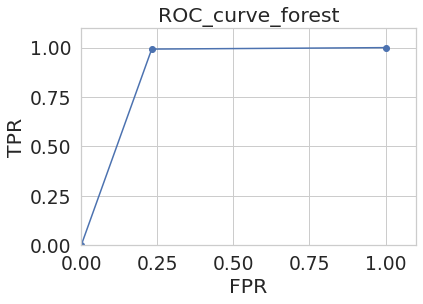

In [21]:
fprs_forest, tprs_forest, thr_forest = roc_curve(y_test, y_pred_forest)
plt.plot(fprs_forest, tprs_forest, marker='o')
plt.ylim([0, 1.1]);plt.xlim([0,1.1])
plt.xlabel('FPR');plt.ylabel('TPR')
plt.title('ROC_curve_forest')

Text(0.5, 1.0, 'ROC_curve_cat_boost')

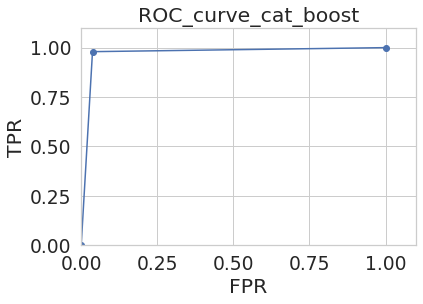

In [22]:
fprs_cat_boost, tprs_cat_boost, thr_cat_boost = roc_curve(y_test, y_pred_catboost)
plt.plot(fprs_cat_boost, tprs_cat_boost, marker='o')
plt.ylim([0, 1.1]);plt.xlim([0,1.1])
plt.xlabel('FPR');plt.ylabel('TPR')
plt.title('ROC_curve_cat_boost')

Теперь можно обучать на полном тренировочном дата сете и получать результаты на тестовом

In [23]:
X_train = train_df.drop(['result'], axis=1)
X_test = test_df
y_train = train_df.result

In [24]:
ss = StandardScaler()
X_train_scaled = ss.fit_transform(X_train)
X_test_scaled = ss.transform(X_test)
y_train = np.array(y_train)

In [ ]:
clf = CatBoostClassifier(**best_params)
clf.fit(X_train_scaled, y_train)

In [26]:
y_prob = clf.predict_proba(X_test_scaled)[:, 1]
result = pd.Series(y_prob)
result.name = 'result'
final_df = pd.concat([test.action_id, result], axis=1)

In [27]:
final_df.to_csv('repo/data/ready_catboost.csv', encoding='utf-8', index=False, columns=['action_id', 'result'])

In [28]:
display(final_df)

,action_id,result
0,act1_249281,0.858759
1,act2_230855,0.775108
2,act1_240724,0.985875
3,act1_83552,0.985143
4,act2_1043301,0.984817
...,...,...
498682,act2_4367092,0.000142
498683,act2_4404220,0.000142
498684,act2_448830,0.000142
498685,act2_450133,0.000142
